In [120]:
from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import skfda
from scipy import ndimage as ndi
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)
reload(utils)

pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

# Proof-of-Concept for one experiment

In [2]:
params = dict(
    experiment_dir="/Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/",
    imaging_scheme="TL/470/410/470/410",
    should_register=False
)

ex_unreg = experiment.PairExperiment(**params).full_pipeline()

12:56:45 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
12:56:45 INFO:Loading Images
12:56:46 INFO:Segmenting pharynxes
12:56:47 INFO:Centering and rotating pharynxes


12:56:56 INFO:Calculating midlines


12:56:57 INFO:Measuring under midlines


12:56:58 INFO:Trimming intensity data


12:56:59 INFO:Calculating redox measurements
12:56:59 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
12:56:59 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
12:57:00 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-profile_data.nc
12:57:00 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47


In [3]:
i410_0 = ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=0)
i470_0 = ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=0)
i410_1 = ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=1)
i470_1 = ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=1)

In [4]:
f410_0, f470_0, w_0 = profile_processing.register_pair(i410_0, i470_0, warp_lam=10 ** -1, rough_nbasis=64)

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x13271f748>])

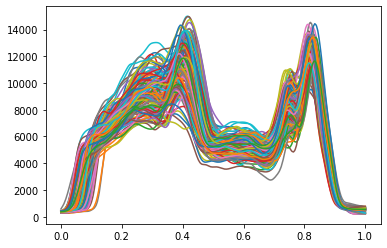

In [123]:
f410_0.plot()

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x130ccc5c0>])

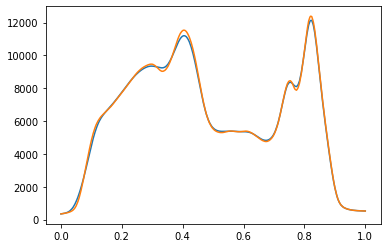

In [132]:
f410_0.mean().plot()
skfda.preprocessing.registration.elastic_registration(f410_0, f410_0.mean(), lam=10**-2).mean().plot()

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1356bb278>])

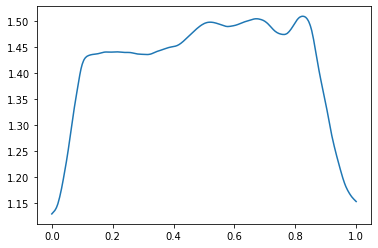

In [136]:
(f410_0 / f470_0).mean().plot()

In [65]:
d_ident = np.abs((np.linspace(0,1,200) - np.squeeze(w_0.to_grid().data_matrix)))

(123, 200)

In [67]:
d_ident.shape[-1]

200

In [91]:
mvmt = ex_unreg.summary_table
mvmt[mvmt.pair == 0].posterior

0      0
1      0
2      0
3      0
4      0
      ..
118    0
119    3
120    0
121    0
122    0
Name: posterior, Length: 615, dtype: int64

In [97]:
mvmt[(mvmt.pair == 0) & (mvmt.region == 'pm3')].posterior

0      0
1      0
2      0
3      0
4      0
      ..
118    0
119    3
120    0
121    0
122    0
Name: posterior, Length: 123, dtype: int64

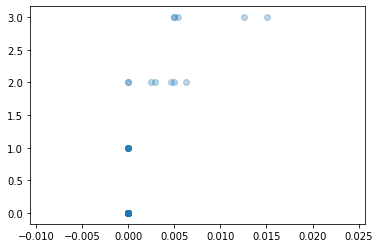

In [100]:
reload(profile_processing);

w0_tbl = profile_processing.summarize_over_regions(d_ident, ex_unreg.regions, rescale=True)
plt.scatter(w0_tbl[w0_tbl.region == 'pm6'].value, mvmt[(mvmt.pair == 0) & (mvmt.region == 'pm3')].posterior, alpha=0.3)

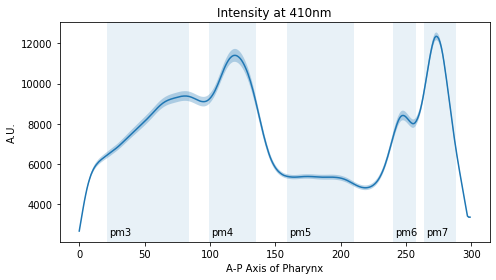

In [36]:
fig, ax = plt.subplots(figsize=(7,4))
plots.plot_profile_avg_with_bounds(ex_unreg.trimmed_profiles.sel(wavelength='410', pair=0), ax=ax)
plots.add_regions_to_axis(ax, ex_unreg.scaled_regions)
ax.set_ylabel('A.U.')
ax.set_xlabel('A-P Axis of Pharynx')
ax.set_title('Intensity at 410nm');
plt.tight_layout();
plt.savefig('/Users/sean/Desktop/ex_i410.png', dpi=300)

ValueError: x and y must be the same size

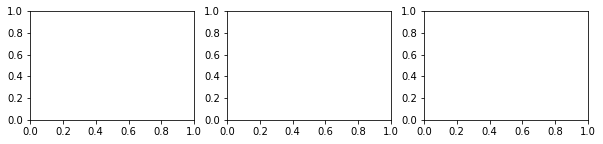

In [46]:
n_pts = 1000
identity = np.linspace(0,1,200)
w_0_data = np.squeeze(w_0.data_matrix)

rmses = utils.rmse(np.tile(identity,(w_0_data.shape[0],1)), w_0_data, axis=1)

df = ex_unreg.summary_table.copy()
df_0 = df[(df.pair == 0) & (df.region == 'pm7')]
df_1 = df[(df.pair == 1) & (df.region == 'pm7')]
df = pd.concat([df_0, df_1])
df['total'] = df.posterior + df.anterior

# # plt.scatter(rmses, df.total.values, alpha=0.5)
# fig, axes = plt.subplots(1,3, figsize=(10,2))
# axes[0].scatter(df.posterior.values, rmses, alpha=0.5)
# axes[0].set_title('Posterior')
# axes[1].scatter(df.anterior.values, rmses, alpha=0.5)
# axes[1].set_title('Anterior')
# axes[2].scatter(df.total.values, rmses, alpha=0.5)
# axes[2].set_title('Total')
# plt.tight_layout()

In [47]:
len(df)

246

# Now let's do it for all experiments

In [102]:
meta_dir = Path("/Users/sean/code/pharynx_redox/data/paired_ratio")

df = da.load_all_summaries(meta_dir)
df = df[(df.strategy == 'single_reg') & (df.region == 'pm3')]
df_0 = df[df.pair == 0]
df_1 = df[df.pair == 1]

df = pd.concat([df_0, df_1])

/Users/sean/code/pharynx_redox/pharynx_redox/data_analysis.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(pd.read_csv(x) for x in sorted(meta_dir.glob("**/*summary*csv")))


In [103]:
rmses = []
warps = []
for pair in tqdm_notebook([0, 1]):
    for exp_dir in tqdm_notebook(list(sorted(meta_dir.iterdir())), leave=False):
        if not exp_dir.is_dir():
            continue
        ex = experiment.PairExperiment(exp_dir, "TL/470/410/470/410", should_register=False).full_pipeline()

        i410_0 = ex.untrimmed_profiles.sel(wavelength='410', pair=pair)
        i470_0 = ex.untrimmed_profiles.sel(wavelength='470', pair=pair)
        _, _, w_0 = profile_processing.register_pair(i410_0, i470_0, warp_lam=10 ** -1, rough_nbasis=64)

        identity = np.linspace(0,1,i410_0.shape[-1])
        w_0_data = np.squeeze(w_0.data_matrix)
        warps.append(w_0)
        rmses.append(utils.rmse(np.tile(identity,(w_0_data.shape[0],1)), w_0_data, axis=1))

03:58:54 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
03:58:54 INFO:Loading Images
03:58:55 INFO:Segmenting pharynxes
03:58:56 INFO:Centering and rotating pharynxes


03:59:05 INFO:Calculating midlines


03:59:07 INFO:Measuring under midlines


03:59:08 INFO:Trimming intensity data
03:59:08 INFO:Calculating redox measurements
03:59:09 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
03:59:09 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
03:59:09 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-profile_data.nc
03:59:09 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
03:59:20 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236
03:59:20 INFO:Loading Images
03:59:21 INFO:Segmenting pharynxes
03:59:22 INFO:Centering and rotating pharynxes


03:59:31 INFO:Calculating midlines


03:59:32 INFO:Measuring under midlines


03:59:33 INFO:Trimming intensity data
03:59:34 INFO:Calculating redox measurements
03:59:34 INFO:Saving 2017_02_23-HD233_HD236 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236
03:59:34 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_23-HD233_HD236-summary_table.csv
03:59:34 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_23-HD233_HD236-profile_data.nc
03:59:34 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236
03:59:43 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236
03:59:43 INFO:Loading Images
03:59:44 INFO:Segmenting pharynxes
03:59:45 INFO:Centering and rotating pharynxes


03:59:54 INFO:Calculating midlines


03:59:55 INFO:Measuring under midlines


03:59:56 INFO:Trimming intensity data
03:59:57 INFO:Calculating redox measurements
03:59:57 INFO:Saving 2017_02_27-HD233_HD236 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236
03:59:57 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_27-HD233_HD236-summary_table.csv
03:59:57 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_27-HD233_HD236-profile_data.nc
03:59:57 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236
04:00:08 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236
04:00:08 INFO:Loading Images
04:00:08 INFO:Segmenting pharynxes
04:00:09 INFO:Centering and rotating pharynxes


04:00:18 INFO:Calculating midlines


04:00:19 INFO:Measuring under midlines


04:00:20 INFO:Trimming intensity data
04:00:21 INFO:Calculating redox measurements
04:00:21 INFO:Saving 2017_03_01_HD233_HD236 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236
04:00:21 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_03_01_HD233_HD236-summary_table.csv
04:00:21 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_03_01_HD233_HD236-profile_data.nc
04:00:21 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236
04:00:31 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev
04:00:31 INFO:Loading Images
04:00:31 INFO:Segmenting pharynxes
04:00:32 INFO:Centering and rotating pharynxes


04:00:38 INFO:Calculating midlines


04:00:38 INFO:Measuring under midlines


04:00:39 INFO:Trimming intensity data
04:00:40 INFO:Calculating redox measurements
04:00:40 INFO:Saving 2017_08_15-HD233_4mM_lev inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev
04:00:40 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_15-HD233_4mM_lev-summary_table.csv
04:00:40 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_15-HD233_4mM_lev-profile_data.nc
04:00:40 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev
04:00:47 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev
04:00:47 INFO:Loading Images
04:00:48 INFO:Segmenting pharynxes
04:00:48 INFO:Centering and rotating pharynxes


04:00:50 INFO:Calculating midlines


04:00:50 INFO:Measuring under midlines


04:00:50 INFO:Trimming intensity data
04:00:51 INFO:Calculating redox measurements
04:00:51 INFO:Saving 2017_08_23-HD233_4mm_lev inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev
04:00:51 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_23-HD233_4mm_lev-summary_table.csv
04:00:51 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_23-HD233_4mm_lev-profile_data.nc
04:00:51 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev
04:00:55 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93
04:00:55 INFO:Loading Images
04:00:55 INFO:Segmenting pharynxes
04:00:56 INFO:Centering and rotating pharynxes


04:01:04 INFO:Calculating midlines


04:01:05 INFO:Measuring under midlines


04:01:06 INFO:Trimming intensity data
04:01:06 INFO:Calculating redox measurements
04:01:07 INFO:Saving 2017_08_24-HD233_SAY93 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93
04:01:07 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_24-HD233_SAY93-summary_table.csv
04:01:07 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_24-HD233_SAY93-profile_data.nc
04:01:07 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93
04:01:16 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev
04:01:16 INFO:Loading Images
04:01:16 INFO:Segmenting pharynxes
04:01:16 INFO:Centering and rotating pharynxes


04:01:19 INFO:Calculating midlines


04:01:20 INFO:Measuring under midlines


04:01:20 INFO:Trimming intensity data
04:01:21 INFO:Calculating redox measurements
04:01:21 INFO:Saving 2017_08_25-HD233_4mm_lev inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev
04:01:21 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_25-HD233_4mm_lev-summary_table.csv
04:01:21 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_25-HD233_4mm_lev-profile_data.nc
04:01:21 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev
04:01:26 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93
04:01:26 INFO:Loading Images
04:01:27 INFO:Segmenting pharynxes
04:01:27 INFO:Centering and rotating pharynxes


04:01:30 INFO:Calculating midlines


04:01:31 INFO:Measuring under midlines


04:01:31 INFO:Trimming intensity data
04:01:31 INFO:Calculating redox measurements
04:01:32 INFO:Saving 2017_08_25-HD233_SAY93 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93
04:01:32 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_25-HD233_SAY93-summary_table.csv
04:01:32 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_25-HD233_SAY93-profile_data.nc
04:01:32 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93
04:01:37 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation
04:01:37 INFO:Loading Images
04:01:37 INFO:Segmenting pharynxes
04:01:39 INFO:Centering and rotating pharynxes


04:01:49 INFO:Calculating midlines


04:01:50 INFO:Measuring under midlines


04:01:51 INFO:Trimming intensity data
04:01:52 INFO:Calculating redox measurements
/Users/sean/.local/share/virtualenvs/worm-testing/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
04:01:52 INFO:Saving 2019_04_03-ASI_ablation inside /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation
04:01:52 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation/analyses/2019-09-10_frame_specific_midlines_with_registration/2019_04_03-ASI_ablation-summary_table.csv
04:01:53 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation/analyses/2019-09-10_frame_specific_midlines_with_registration/2019_04_03-ASI_ablation-profile_data.nc
04:01:53 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation


04:02:03 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:02:03 INFO:Loading Images
04:02:04 INFO:Segmenting pharynxes
04:02:05 INFO:Centering and rotating pharynxes


04:02:15 INFO:Calculating midlines


04:02:16 INFO:Measuring under midlines


04:02:17 INFO:Trimming intensity data
04:02:18 INFO:Calculating redox measurements
04:02:18 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:02:18 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
04:02:19 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-profile_data.nc
04:02:19 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:02:29 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236
04:02:29 INFO:Loading Images
04:02:30 INFO:Segmenting pharynxes
04:02:31 INFO:Centering and rotating pharynxes


04:02:40 INFO:Calculating midlines


04:02:41 INFO:Measuring under midlines


04:02:43 INFO:Trimming intensity data
04:02:43 INFO:Calculating redox measurements
04:02:44 INFO:Saving 2017_02_23-HD233_HD236 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236
04:02:44 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_23-HD233_HD236-summary_table.csv
04:02:44 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_23-HD233_HD236-profile_data.nc
04:02:44 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236
04:02:54 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236
04:02:54 INFO:Loading Images
04:02:55 INFO:Segmenting pharynxes
04:02:57 INFO:Centering and rotating pharynxes


04:03:05 INFO:Calculating midlines


04:03:07 INFO:Measuring under midlines


04:03:08 INFO:Trimming intensity data
04:03:08 INFO:Calculating redox measurements
04:03:09 INFO:Saving 2017_02_27-HD233_HD236 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236
04:03:09 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_27-HD233_HD236-summary_table.csv
04:03:09 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_27-HD233_HD236-profile_data.nc
04:03:09 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236
04:03:19 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236
04:03:19 INFO:Loading Images
04:03:20 INFO:Segmenting pharynxes
04:03:21 INFO:Centering and rotating pharynxes


04:03:31 INFO:Calculating midlines


04:03:32 INFO:Measuring under midlines


04:03:33 INFO:Trimming intensity data
04:03:34 INFO:Calculating redox measurements
04:03:34 INFO:Saving 2017_03_01_HD233_HD236 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236
04:03:34 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_03_01_HD233_HD236-summary_table.csv
04:03:35 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_03_01_HD233_HD236-profile_data.nc
04:03:35 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236
04:03:45 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev
04:03:45 INFO:Loading Images
04:03:45 INFO:Segmenting pharynxes
04:03:46 INFO:Centering and rotating pharynxes


04:03:52 INFO:Calculating midlines


04:03:53 INFO:Measuring under midlines


04:03:53 INFO:Trimming intensity data
04:03:54 INFO:Calculating redox measurements
04:03:54 INFO:Saving 2017_08_15-HD233_4mM_lev inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev
04:03:54 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_15-HD233_4mM_lev-summary_table.csv
04:03:54 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_15-HD233_4mM_lev-profile_data.nc
04:03:54 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev
04:04:02 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev
04:04:02 INFO:Loading Images
04:04:02 INFO:Segmenting pharynxes
04:04:02 INFO:Centering and rotating pharynxes


04:04:04 INFO:Calculating midlines


04:04:04 INFO:Measuring under midlines


04:04:05 INFO:Trimming intensity data
04:04:05 INFO:Calculating redox measurements
04:04:05 INFO:Saving 2017_08_23-HD233_4mm_lev inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev
04:04:05 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_23-HD233_4mm_lev-summary_table.csv
04:04:05 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_23-HD233_4mm_lev-profile_data.nc
04:04:05 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev
04:04:09 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93
04:04:09 INFO:Loading Images
04:04:10 INFO:Segmenting pharynxes
04:04:11 INFO:Centering and rotating pharynxes


04:04:17 INFO:Calculating midlines


04:04:17 INFO:Measuring under midlines


04:04:18 INFO:Trimming intensity data
04:04:19 INFO:Calculating redox measurements
04:04:19 INFO:Saving 2017_08_24-HD233_SAY93 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93
04:04:19 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_24-HD233_SAY93-summary_table.csv
04:04:19 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_24-HD233_SAY93-profile_data.nc
04:04:19 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93
04:04:27 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev
04:04:27 INFO:Loading Images
04:04:27 INFO:Segmenting pharynxes
04:04:28 INFO:Centering and rotating pharynxes


04:04:30 INFO:Calculating midlines


04:04:30 INFO:Measuring under midlines


04:04:31 INFO:Trimming intensity data
04:04:31 INFO:Calculating redox measurements
04:04:31 INFO:Saving 2017_08_25-HD233_4mm_lev inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev
04:04:31 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_25-HD233_4mm_lev-summary_table.csv
04:04:32 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_25-HD233_4mm_lev-profile_data.nc
04:04:32 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev
04:04:36 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93
04:04:36 INFO:Loading Images
04:04:36 INFO:Segmenting pharynxes
04:04:36 INFO:Centering and rotating pharynxes


04:04:41 INFO:Calculating midlines


04:04:42 INFO:Measuring under midlines


04:04:42 INFO:Trimming intensity data
04:04:42 INFO:Calculating redox measurements
04:04:43 INFO:Saving 2017_08_25-HD233_SAY93 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93
04:04:43 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_25-HD233_SAY93-summary_table.csv
04:04:43 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_08_25-HD233_SAY93-profile_data.nc
04:04:43 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93
04:04:48 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation
04:04:48 INFO:Loading Images
04:04:49 INFO:Segmenting pharynxes
04:04:50 INFO:Centering and rotating pharynxes


04:05:04 INFO:Calculating midlines


04:05:06 INFO:Measuring under midlines


04:05:07 INFO:Trimming intensity data
04:05:08 INFO:Calculating redox measurements
/Users/sean/.local/share/virtualenvs/worm-testing/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
04:05:09 INFO:Saving 2019_04_03-ASI_ablation inside /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation
04:05:09 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation/analyses/2019-09-10_frame_specific_midlines_with_registration/2019_04_03-ASI_ablation-summary_table.csv
04:05:10 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation/analyses/2019-09-10_frame_specific_midlines_with_registration/2019_04_03-ASI_ablation-profile_data.nc
04:05:10 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation


In [52]:
from sklearn.metrics import mean_squared_error as mse
mses = []
for exp_warp in warps:
    for warp in exp_warp:
        mses.append(mse(identity, np.squeeze(warp.data_matrix)))
mses = np.array(mses)

In [108]:
warps[0][0].data_matrix.shape

(1, 200, 1)

In [111]:
didents = []
for exp_warp in warps:
    for warp in exp_warp:
        didents.append(np.abs((np.linspace(0,1,warp.data_matrix.shape[1]) - np.squeeze(warp.to_grid().data_matrix))))

didents = np.array(didents)

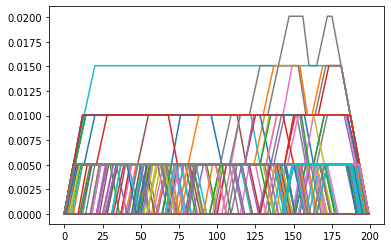

In [115]:
plt.plot(didents.T);

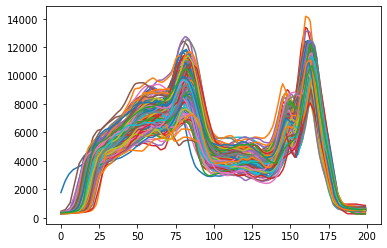

In [117]:
plt.plot(i410_0.values.T);

In [53]:
rmses = np.hstack(rmses)

In [101]:
rmses

NameError: name 'rmses' is not defined

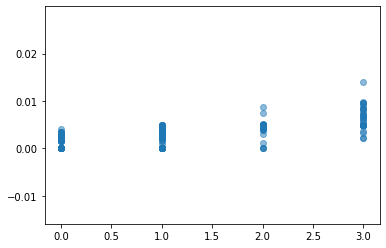

In [55]:
plt.scatter(df.posterior.values, np.sqrt(mses), alpha=0.5)

In [56]:
all_df = pd.DataFrame()
all_df['anterior'] = df.anterior
all_df['posterior'] = df.posterior
all_df['rmse'] = np.sqrt(mses)

In [57]:
all_df.to_csv('/Users/sean/Desktop/all_df.csv')

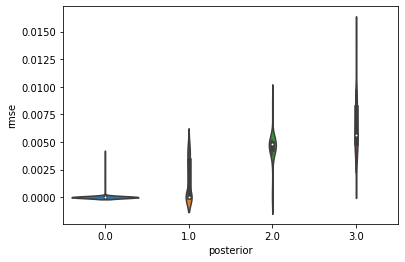

In [58]:
sns.violinplot(x='posterior', y='rmse', data=all_df)

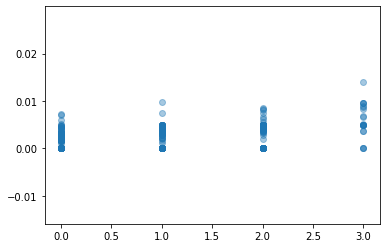

In [59]:
plt.scatter(df.anterior.values, np.sqrt(mses), alpha=0.4)

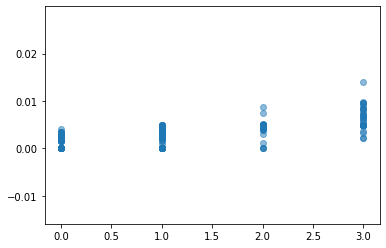

In [62]:
plt.scatter(all_df.posterior.values, all_df.rmse, alpha=0.5)

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [69]:
from sklearn.linear_model import LogisticRegression

In [188]:
X = all_df.rmse.values.reshape(-1,1)
y_true = all_df.posterior > 1

extreme_idx = df[(df.posterior == 0) | (df.posterior == 3)].index
X_extreme = X[extreme_idx]
y_true_extreme = y_true.values[extreme_idx]

array([[97.36279401,  2.63720599],
       [14.52991453, 85.47008547]])

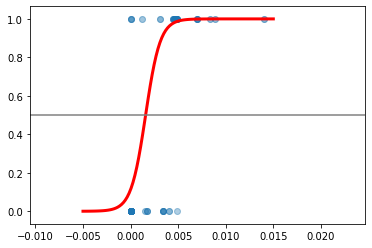

In [200]:
clf = LogisticRegression(
    class_weight='balanced',
    solver='liblinear',
    C=1e5
)
clf.fit(X_extreme, y_true_extreme)

y_pred_extreme = clf.predict(X_extreme)

from scipy.special import expit

plt.scatter(X_extreme, y_true_extreme, alpha=0.1)
X_test = np.linspace(-.005,.015, 100)
loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)
plt.axhline(.5, color='.5')

cm = confusion_matrix(y_true_extreme, y_pred_extreme)
100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]